# Interaction calculator
Calculate the degree of synergy between pairs of interactions.

Interactions are quantified following [supplementary note 15](https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-023-01905-6/MediaObjects/41587_2023_1905_MOESM1_ESM.pdf) from this paper: [Predicting transcriptional outcomes of novel multigene perturbations with GEARS
](https://www.nature.com/articles/s41587-023-01905-6#peer-review)

The previous paper deals with single-cell data, while we only have bulk data, so we can skip some averaging steps. 

For two gene targets $a$ and $b$, we can calculate vectors of proteomics measurements for each CRISPRi perturbation and the combination:

$\bar{\textbf{g}}^k$, where $ k\in \{a, b, a+b\}$

where $k$ is a perturbation index and $\bar{\textbf{g}}$ is a vector of (normalized) protein expression.

Then, we can calculate the change in mean protein expression compared to controls ($\bar{\textbf{g}}^{ctrl}$):

$\delta\bar{\textbf{g}}^k = \bar{\textbf{g}}^k - \bar{\textbf{g}}^{ctrl}$

Then, we fit a linear model:

$\delta\bar{\textbf{g}}^{(a+b)} = c_a\delta\bar{\textbf{g}}^{a} + c_b \delta\bar{\textbf{g}}^{b} + \epsilon$

Where $c_k$ are model coefficients. We fit the model using a robust regressor, the Theil-Sen estimator.

Code from GEARS can be found around [here](https://github.com/snap-stanford/GEARS/blob/5866c6b71633812a0e957b2df90465d81a023022/gears/utils.py#L480).

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import TheilSenRegressor
import re

In [33]:
try:
    from dcor import distance_correlation    
except ModuleNotFoundError:
    !pip install dcor
    from dcor import distance_correlation

try: 
    from adjustText import adjust_text
except ModuleNotFoundError:
    !pip install adjustText 
    from adjustText import adjust_text 

## Import data


In [3]:
data_file = './data/normalized_proteomics_pivot.csv'
omics = pd.read_csv(data_file, index_col=0)
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0008,PP_0009,PP_0010,...,PP_5417,PP_5418,PP_5419,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,0.785908,1.095724,1.152434,...,0.952586,0.000000,1.086405,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,0.967062,1.054531,1.054544,...,1.053211,0.022315,0.781209,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,1.212164,0.958415,0.958498,...,0.955814,6.881715,1.060845,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,0.793051,1.252256,1.137690,...,1.037332,0.021247,1.206203,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.205255,1.172617,0.838294,...,0.899485,0.045492,0.884382,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.948802,0.521773,0.651952,...,0.871891,0.028549,0.024475,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.884128,0.634366,1.168989,...,0.767842,0.029056,0.024909,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.186492,0.392700,0.869069,...,0.892056,0.084788,0.010848,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.726780


Drop any rows (lines) that have missing isoprenol data and any columns (targets) that have any missing proteomics measurements.

In [4]:
omics.loc[omics['isoprenol'].isna(), 'isoprenol']
omics = omics.dropna(axis = 0, how = 'any', subset=['isoprenol'])
omics = omics.dropna(axis = 1, how = 'any')
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0008,PP_0009,PP_0010,...,PP_5417,PP_5418,PP_5419,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,0.785908,1.095724,1.152434,...,0.952586,0.000000,1.086405,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,0.967062,1.054531,1.054544,...,1.053211,0.022315,0.781209,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,1.212164,0.958415,0.958498,...,0.955814,6.881715,1.060845,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,0.793051,1.252256,1.137690,...,1.037332,0.021247,1.206203,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.205255,1.172617,0.838294,...,0.899485,0.045492,0.884382,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.948802,0.521773,0.651952,...,0.871891,0.028549,0.024475,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.884128,0.634366,1.168989,...,0.767842,0.029056,0.024909,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.186492,0.392700,0.869069,...,0.892056,0.084788,0.010848,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.726780


Get protein measurements

In [5]:
protein_measurements = omics.columns[:-1]
protein_measurements

Index(['MM_1762', 'PP_0001', 'PP_0002', 'PP_0003', 'PP_0004', 'PP_0005',
       'PP_0006', 'PP_0008', 'PP_0009', 'PP_0010',
       ...
       'PP_5416', 'PP_5417', 'PP_5418', 'PP_5419', 'SPy_1046', 'YNR043W',
       'aacC1', 'b4055 JW4015', 'mvaS', 'neo'],
      dtype='object', length=2041)

Define matrices for ML

In [6]:
X = omics[protein_measurements]
y = omics['isoprenol']

Add extra information to the omics dataframe

In [7]:
omics_index = omics.index.values
cycle_label = [int(x[-1]) for x in omics_index]
num_grna = [x.count('PP') for x in omics_index]
is_control = ['ontrol' in x for x in omics_index]
target_list = [re.findall('PP_\d{4}', x) for x in omics_index]


In [8]:
omics['cycle_label'] = cycle_label
omics['num_grna'] = num_grna
omics['is_control'] = is_control
omics['target_list'] = target_list
omics['line_name_norep'] = [x.split('-')[0] for x in omics_index]
omics.loc[omics['is_control'] == 1, 'line_name_norep'] = 'Control'
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0008,PP_0009,PP_0010,...,aacC1,b4055 JW4015,mvaS,neo,isoprenol,cycle_label,num_grna,is_control,target_list,line_name_norep
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,0.785908,1.095724,1.152434,...,1.042664,1.075991,0.995796,1.110129,1.024392,1,0,True,[],Control
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,0.967062,1.054531,1.054544,...,1.094487,1.224033,1.056521,1.058979,1.120367,1,0,True,[],Control
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,1.212164,0.958415,0.958498,...,1.093481,0.905480,1.047002,1.131022,1.178920,1,0,True,[],Control
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,0.793051,1.252256,1.137690,...,0.950900,0.904057,0.931308,0.896219,0.720284,1,0,True,[],Control
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.205255,1.172617,0.838294,...,0.883845,0.997991,0.853035,1.083941,1.030501,1,0,True,[],Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.948802,0.521773,0.651952,...,0.033226,1.222933,1.042099,1.008801,2.153361,1,1,False,[PP_5419],PP_5419
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.884128,0.634366,1.168989,...,0.009552,1.087679,1.080355,1.079077,2.397354,1,1,False,[PP_5419],PP_5419
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.186492,0.392700,0.869069,...,0.000445,0.730318,0.143453,1.447907,0.726780,1,1,False,[PP_5420],PP_5420


## Write function to calculate response characteristics

In [9]:
def get_mean_proteomics(target, omics, protein_measurements):
    omics_idx = omics['line_name_norep'] == target
    omics_values = omics.loc[omics_idx, protein_measurements].mean().values
    return omics_values.reshape(len(omics_values), 1)

def calculate_interaction(target_pair, omics, protein_measurements):
    target1, target2 = re.findall('PP_\d{4}', target_pair)
    print(f"Finding interactions for target1 = {target1}, target2 = {target2}, input target_pair = {target_pair}")
    target1_expr = get_mean_proteomics(target1, omics, protein_measurements)
    target2_expr = get_mean_proteomics(target2, omics, protein_measurements)
    pair_expr = get_mean_proteomics(target_pair, omics, protein_measurements)
    
    X = np.hstack([target1_expr, target2_expr])
    print(f"shape X: {X.shape}\t shape y.ravel(): {pair_expr.shape}")
    results = {}
    results['ts'] = TheilSenRegressor(fit_intercept=False,
                                      max_subpopulation=1e5,
                                      max_iter=1000,
                                      random_state=42)
    results['ts'].fit(X, pair_expr.ravel())
    Zts = results['ts'].predict(X)
    results['c1'] = results['ts'].coef_[0]
    results['c2'] = results['ts'].coef_[1]
    results['mag'] = np.sqrt((results['c1']**2 + results['c2']**2))
    return results

In [10]:
calculate_interaction('PP_0814_PP_4862', omics, ['isoprenol'])

Finding interactions for target1 = PP_0814, target2 = PP_4862, input target_pair = PP_0814_PP_4862
shape X: (1, 2)	 shape y.ravel(): (1, 1)


{'ts': TheilSenRegressor(fit_intercept=False, max_iter=1000,
                   max_subpopulation=100000.0, random_state=42),
 'c1': 0.9734957986652399,
 'c2': 0.4485620998126517,
 'mag': 1.071868474863968}

## Use functions to calculate interactions for all pairs

In [11]:
np.sort(omics['line_name_norep'].unique())

array(['Control', 'PP_0001', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106',
       'PP_0168', 'PP_0225', 'PP_0226', 'PP_0226_PP_0437_PP_0751',
       'PP_0226_PP_0597_PP_4678', 'PP_0226_PP_0897_PP_5288',
       'PP_0226_PP_2339_PP_3365', 'PP_0277', 'PP_0338', 'PP_0362',
       'PP_0368', 'PP_0368_PP_0597', 'PP_0368_PP_0812_PP_0944',
       'PP_0368_PP_4191_PP_4192', 'PP_0437', 'PP_0437_PP_0528_PP_3578',
       'PP_0437_PP_3365', 'PP_0437_PP_4116', 'PP_0528', 'PP_0528_PP_5288',
       'PP_0548', 'PP_0582', 'PP_0597', 'PP_0597_PP_1769_PP_4862',
       'PP_0654', 'PP_0658', 'PP_0658_PP_0815_PP_4187',
       'PP_0658_PP_1506_PP_3071', 'PP_0658_PP_2136', 'PP_0691', 'PP_0751',
       'PP_0751_PP_1620_PP_4678', 'PP_0774', 'PP_0774_PP_1607_PP_3578',
       'PP_0774_PP_1769', 'PP_0774_PP_2213_PP_5288', 'PP_0806', 'PP_0812',
       'PP_0812_PP_2095', 'PP_0812_PP_4121', 'PP_0813',
       'PP_0813_PP_1769_PP_4191', 'PP_0813_PP_4120', 'PP_0813_PP_4189',
       'PP_0813_PP_4549_PP_5288', 'PP_0814', 'PP

In [12]:
name_list = omics.loc[omics['num_grna'] == 2, 'line_name_norep'].unique()
results_list = []
all_single_targets = []
results_dict = {}
# for idx, row in omics[omics['num_grna'] == 2].iterrows():
#     name = row['line_name_norep']
#     name_list.append(name)
for idx, name in enumerate(name_list):
    targets = re.findall('PP_\d{4}', name)
    all_single_targets.append(targets[0])
    all_single_targets.append(targets[1])
    if (any(omics['line_name_norep'] == targets[0])) & (any(omics['line_name_norep'] == targets[1])):
        print('good')
        results_list.append(calculate_interaction(name, omics, ['isoprenol']))
        results_dict[name] = results_list[-1]
    else:
        name_list = np.delete(name_list, name_list == name)
        print(name)
        print('bad')

good
Finding interactions for target1 = PP_0368, target2 = PP_0597, input target_pair = PP_0368_PP_0597
shape X: (1, 2)	 shape y.ravel(): (1, 1)
good
Finding interactions for target1 = PP_0437, target2 = PP_3365, input target_pair = PP_0437_PP_3365
shape X: (1, 2)	 shape y.ravel(): (1, 1)
good
Finding interactions for target1 = PP_0437, target2 = PP_4116, input target_pair = PP_0437_PP_4116
shape X: (1, 2)	 shape y.ravel(): (1, 1)
good
Finding interactions for target1 = PP_0528, target2 = PP_5288, input target_pair = PP_0528_PP_5288
shape X: (1, 2)	 shape y.ravel(): (1, 1)
good
Finding interactions for target1 = PP_0658, target2 = PP_2136, input target_pair = PP_0658_PP_2136
shape X: (1, 2)	 shape y.ravel(): (1, 1)
good
Finding interactions for target1 = PP_0774, target2 = PP_1769, input target_pair = PP_0774_PP_1769
shape X: (1, 2)	 shape y.ravel(): (1, 1)
good
Finding interactions for target1 = PP_0812, target2 = PP_2095, input target_pair = PP_0812_PP_2095
shape X: (1, 2)	 shape y.r

In [13]:
all_single_targets = np.unique(np.array(all_single_targets))

In [14]:
results_list
len(results_list)

26

In [15]:
mag_df = pd.DataFrame(columns = ['t1', 't2', 'mag'])
mag_df
mag_df['t1'] = [re.findall('PP_\d{4}', x)[0] for x in name_list]
mag_df['t2'] = [re.findall('PP_\d{4}', x)[1] for x in name_list]
mag_df['mag'] = [x['mag'] for x in results_list]

In [16]:
mag_df

,t1,t2,mag
0,PP_0368,PP_0597,0.962951
1,PP_0437,PP_3365,0.922352
2,PP_0437,PP_4116,0.957858
3,PP_0528,PP_5288,0.987817
4,PP_0658,PP_2136,0.918277
5,PP_0774,PP_1769,0.703462
6,PP_0812,PP_2095,0.863829
7,PP_0812,PP_4121,1.062614
8,PP_0813,PP_4120,0.713150
9,PP_0813,PP_4189,0.941809


In [28]:
mag_df['isoprenol'] = mag_df.apply(lambda x: get_mean_proteomics(f"{x['t1']}_{x['t2']}", omics, ['isoprenol'])[0][0] , axis = 1)
mag_df

,t1,t2,mag,isoprenol
0,PP_0368,PP_0597,0.962951,1.661970
1,PP_0437,PP_3365,0.922352,1.577569
2,PP_0437,PP_4116,0.957858,1.529031
3,PP_0528,PP_5288,0.987817,2.447712
4,PP_0658,PP_2136,0.918277,1.474363
5,PP_0774,PP_1769,0.703462,1.262523
6,PP_0812,PP_2095,0.863829,1.366692
7,PP_0812,PP_4121,1.062614,1.782339
8,PP_0813,PP_4120,0.713150,1.646946
9,PP_0813,PP_4189,0.941809,2.340433


10

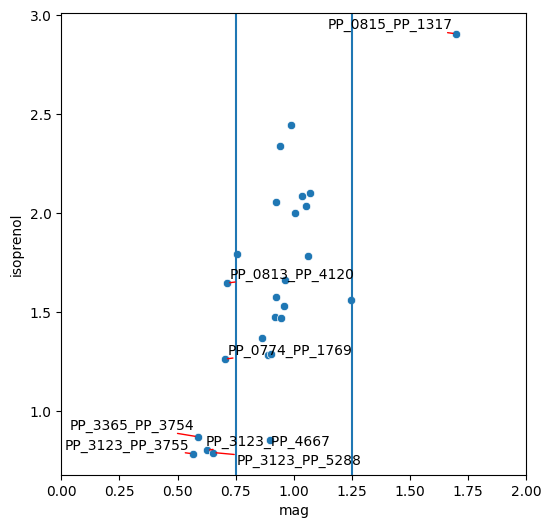

In [50]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(mag_df, x = 'mag', y = 'isoprenol', ax = ax)
texts = []
thresh = 0.25
for idx, srs in mag_df.iterrows():
    if np.abs((srs['mag'] - 1)) > thresh:
        lbl = f"{srs['t1']}_{srs['t2']}"
        text = plt.text(srs['mag'], srs['isoprenol'], lbl, fontsize = 10)
        texts.append(text)
ax.set_xlim([0, 2])
ax.axvline(1-thresh)
ax.axvline(1+thresh)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))



In [17]:
mag_df_pivot = mag_df.pivot(index = 't1', columns = 't2', values = 'mag')

In [18]:
# gp = glue.pivot(index="Model", columns="Task", values="Score")
# gp

<Axes: xlabel='t2', ylabel='t1'>

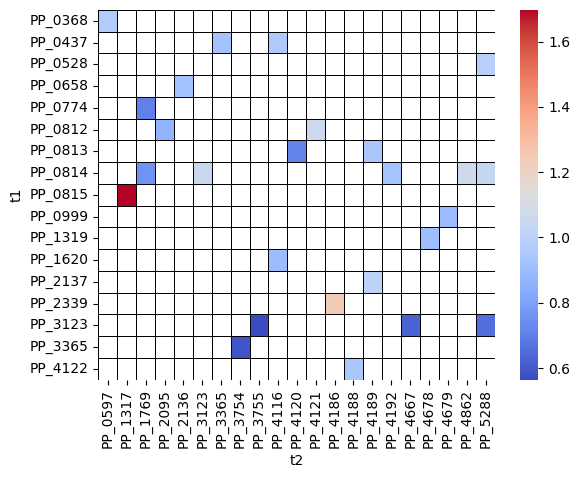

In [19]:
sns.heatmap(mag_df_pivot, cmap = 'coolwarm', linewidth = 0.5, linecolor = 'k')

In [20]:
mag_df2 = pd.DataFrame(index = all_single_targets, columns = all_single_targets)
for idx, n in enumerate(name_list):
    t1, t2 = re.findall('PP_\d{4}', n)
    mag_df2.loc[t1, t2] = results_list[idx]['mag']
    mag_df2.loc[t2, t1] = results_list[idx]['mag']

mag_df2 = mag_df2[mag_df2.columns].astype(float)

<Axes: >

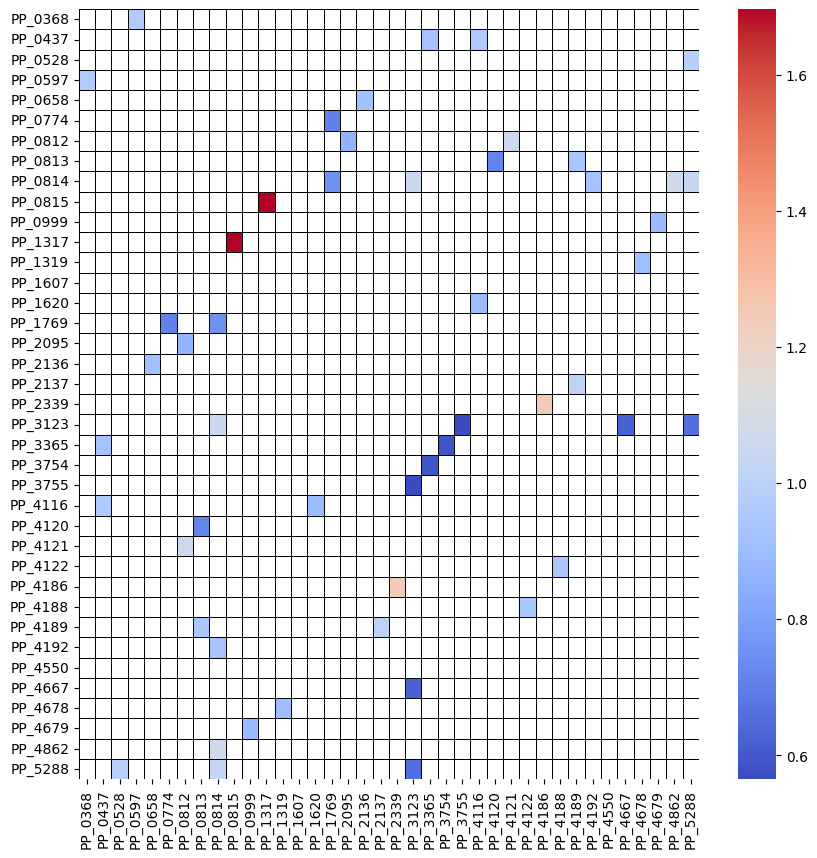

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(mag_df2, cmap = 'coolwarm',
            linewidth = 0.5, linecolor = 'k',
            ax = ax)

## Examine neomorphism
Neomorphism/model fit is defined as:

$corr[c_a\textbf{a} + c_b\textbf{b}, \textbf{ab}]$

I can see which proteins are well fit and which are poorly fit by looking at these correlations.

NOTE they recommend using *distance* correlation which is different than normal pearsons correlation.

In [22]:
name_list

array(['PP_0368_PP_0597', 'PP_0437_PP_3365', 'PP_0437_PP_4116',
       'PP_0528_PP_5288', 'PP_0658_PP_2136', 'PP_0774_PP_1769',
       'PP_0812_PP_2095', 'PP_0812_PP_4121', 'PP_0813_PP_4120',
       'PP_0813_PP_4189', 'PP_0814_PP_1769', 'PP_0814_PP_3123',
       'PP_0814_PP_4192', 'PP_0814_PP_4862', 'PP_0814_PP_5288',
       'PP_0815_PP_1317', 'PP_0999_PP_4679', 'PP_1319_PP_4678',
       'PP_1620_PP_4116', 'PP_2137_PP_4189', 'PP_2339_PP_4186',
       'PP_3123_PP_3755', 'PP_3123_PP_4667', 'PP_3123_PP_5288',
       'PP_3365_PP_3754', 'PP_4122_PP_4188'], dtype=object)

In [23]:
sorted_mag_df = mag_df.sort_values('mag', ascending = False).reset_index(drop = True)
sorted_mag_df

,t1,t2,mag
0,PP_0815,PP_1317,1.696490
1,PP_2339,PP_4186,1.244547
2,PP_0814,PP_4862,1.071868
3,PP_0812,PP_4121,1.062614
4,PP_0814,PP_3123,1.053504
5,PP_0814,PP_5288,1.033824
6,PP_2137,PP_4189,1.004844
7,PP_0528,PP_5288,0.987817
8,PP_0368,PP_0597,0.962951
9,PP_0437,PP_4116,0.957858


In [24]:
t1_analysis = sorted_mag_df.loc[0, 't1']
t2_analysis = sorted_mag_df.loc[0, 't2']
pair_analysis = f"{t1_analysis}_{t2_analysis}"

t1_prot = get_mean_proteomics(t1_analysis, omics, protein_measurements)
t2_prot = get_mean_proteomics(t2_analysis, omics, protein_measurements)
pair_prot = get_mean_proteomics(pair_analysis, omics, protein_measurements)

model_analysis = results_dict[pair_analysis]['ts']
X = np.hstack([t1_prot, t2_prot])
pair_pred = model_analysis.predict(X)

fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(pair_pred, pair_prot, alpha = 0.5, color = 'k')
ax.plot([0, 100], [0, 100], 'k')
ax.set_xlabel('

SyntaxError: unterminated string literal (detected at line 16) (4108842489.py, line 16)

In [ ]:
protein_measurements